Set up Colab requirements if in Colab, or autoreload if in jupyter

In [1]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

In [2]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns
import datetime
import random

sns.set_style('white')


In [4]:
params = {'EWM_SPAN': 3,
          'MEDFILT_SIZE': 4,
          'LOOKBACK_DISTDIFF': 5,
          'LANE_CHANGE_DURATION': 8,
          'ROLLING_SUM_SIZE': 1,
          'CUTOFF_THRESHOLD': 1.5}

lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()
device_names = [x[7:-4] for x in trip_names[0]]

for i in range(3): #add assumed start and end of lane change
    lca_dfs[i]['t_start_approx'] = lca_dfs[i]['t_lc'] - params['LANE_CHANGE_DURATION']/2
    lca_dfs[i]['t_end_approx'] = lca_dfs[i]['t_lc']  + params['LANE_CHANGE_DURATION']/2

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

# Calculate offset and append to all dataframes
The output of the current cell is already stored and loaded - leave commented out

In [10]:
# from calculate_offset import batch_append_offset
# trip_dfs_out = batch_append_offset(trip_dfs, trip_names, road_dfs, save_path=None)

# Create labeled time windows

Select trip and device

<img src="figures/sections.jpg" width=200 height=300 />

Calculate signals

# Calculate detection

Metrics:

Hit (True Positive): A lane change was detected (in the correct direction) at most half a detection window before and after a lane change annotation (ground truth).  
Miss (False Negative): A lane change was annotated but no detection signal was found W/2 before and after 

# To do : remove speeds <40 kmh (check if reduces false positives)

In [5]:
# Detection signal
def calculate_detection_signals(trip_df, signal_name, ROLLING_SUM_SIZE,CUTOFF_THRESHOLD):
    trip_df['detection_right'] = (trip_df[signal_name].rolling(ROLLING_SUM_SIZE)
                                  .sum()>CUTOFF_THRESHOLD).astype(int).diff()
    trip_df['detection_left'] =  (trip_df[signal_name].rolling(ROLLING_SUM_SIZE)
                                  .sum()<-CUTOFF_THRESHOLD).astype(int).diff()

    trip_df['detection'] = (trip_df['detection_right']==1)*1 - (trip_df['detection_left']==1)*1
    trip_df['detection'] = trip_df['detection'].replace([-1, 0, 1],['left', 'none', 'right'])
    return trip_df
    
def get_results(lca_df, trip_df, LANE_CHANGE_DURATION):
    '''takes a trip_df (with a detection signal) and calculates results (TP, precision, recall, F1 etc) '''
    lca_df['detected'] = ['none']*len(lca_df)
    
    
    for ix_row, lca_row in lca_df.iterrows(): # for all annotated lane changes in trip
            detection_window = trip_df[trip_df.t.between(lca_row.t_start_approx, 
                                                         lca_row.t_end_approx)]
            if 1 in list(detection_window.detection_right): # if in the detection window, a right lane change was present
                lca_df.loc[ix_row,'detected']='right' 
            if 1 in list(detection_window.detection_left):
                lca_df.loc[ix_row,'detected']='left'

    lca_df.loc[lca_df.direction == lca_df.detected, 'result'] = 'TP' 
    lca_df.loc[lca_df.detected=='none', 'result'] = 'FN'
    TP = lca_df.result.value_counts()['TP']
    try:
        FN = lca_df.result.value_counts()['FN']
    except:
        FN=0

    ## false positives
    TP_detectionperspective = 0
    FP = 0

    for direction in ['left', 'right']:
        for t_detection in trip_df[trip_df[f'detection_{direction}']==1].t:
            lowerbound = t_detection - LANE_CHANGE_DURATION / 2
            upperbound = t_detection + LANE_CHANGE_DURATION / 2
            lane_changes_found = lca_df[lca_df.t_lc.between(lowerbound, upperbound)]
            if len(lane_changes_found) > 0:
                if lane_changes_found.direction.iloc[0] == direction:
                    TP_detectionperspective +=1
                else: 
                    FP +=1
            else: 
                FP+=1
                
    precision, recall, f1 = precision_recall_f1(TP,FN,FP)
    return TP, TP_detectionperspective, FP, FN, precision, recall, f1



In [6]:
ewm_span_tests = [2, 3, 4, 5]
lookback_distdiff_tests = [3, 4, 5, 6]

rolling_sum_size_tests = [3, 4, 5, 6]
cutoff_threshold_tests = [1.4, 1.5, 1.6, 1.7, 1.8]


In [7]:
result_df = pd.DataFrame(columns = ['trip_nr','dev_nr', 'sections', 'trip_name', 
                                    'signal_name', 'EWM_SPAN', 'LOOKBACK_DISTDIFF',
                                    'LANE_CHANGE_DURATION','ROLLING_SUM_SIZE', 'CUTOFF_THRESHOLD', 
                                    'precision', 'recall', 'f1', 'timestamp'])



In [8]:
trip_dfs = calculate_signals_alltrips(trip_dfs, params)

dev_nr = 1
trip_nr = 2
sections = 'all'#['A', 'M']
signal_name = 'lookback_offset_ewmfilt' #'proj_lat_dist_ewmfilt'

best_f1 = []
f1_highest = 0
# for ewm_span in [1, 3, 5]: 
#     params['EWM_SPAN'] = ewm_span
#     trip_df = calculate_signals_trip(trip_df, params)
for cutoff_thres in np.arange(1.4, 3, 0.2):
    params['CUTOFF_THRESHOLD']=cutoff_thres

    tp_total=0
    fp_total=0
    fn_total=0

    for dev_nr in [0, 1, 3, 4]: #only 1 Hz values
        for trip_nr in range(3):
            trip_df, lca_df, trip_name = selector(trip_dfs,lca_dfs, trip_names, trip_nr, dev_nr, sections = sections, road_type='all')




            trip_df = calculate_detection_signals(trip_df, signal_name, params['ROLLING_SUM_SIZE'],params['CUTOFF_THRESHOLD'])
            tp, tp2, fp, fn, precision, recall, f1 = get_results(lca_df,trip_df, params['LANE_CHANGE_DURATION'])
            tp_total+=tp
            fp_total+=fp
            fn_total+=fn
            now = str(datetime.datetime.now())
            result_df.loc[len(result_df)] = [trip_nr, dev_nr, sections, trip_name, signal_name,
                                             params['EWM_SPAN'], params['LOOKBACK_DISTDIFF'],
                                             params['LANE_CHANGE_DURATION'], params['ROLLING_SUM_SIZE'], 
                                             params['CUTOFF_THRESHOLD'], precision, recall, f1, now]






'2022-02-10 11:19:01'

In [9]:
timestamp = str(datetime.datetime.now())[:-7]
result_df.to_csv(f'results/{timestamp}_results.csv', index=False)

In [10]:
result_df[::-1][:30]

,trip_nr,dev_nr,sections,trip_name,signal_name,EWM_SPAN,LOOKBACK_DISTDIFF,LANE_CHANGE_DURATION,ROLLING_SUM_SIZE,CUTOFF_THRESHOLD,precision,recall,f1,timestamp
95,2,4,all,03 GPS S9.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.650000,0.493671,0.561151,2022-02-09 14:31:11
94,1,4,all,02 GPS S9.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.552632,0.575342,0.563758,2022-02-09 14:31:11
93,0,4,all,01 GPS S9.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.674419,0.517857,0.585859,2022-02-09 14:31:11
92,2,3,all,03 GPS P20.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.552632,0.552632,0.552632,2022-02-09 14:31:11
91,1,3,all,02 GPS P20.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.489130,0.616438,0.545455,2022-02-09 14:31:11
90,0,3,all,01 GPS P20.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.484375,0.584906,0.529915,2022-02-09 14:31:10
89,2,1,all,03 GPS GoPro downsampled (last).csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.679245,0.455696,0.545455,2022-02-09 14:31:10
88,1,1,all,02 GPS GoPro downsampled (last).csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.638889,0.621622,0.630137,2022-02-09 14:31:10
87,0,1,all,01 GPS GoPro downsampled (last).csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.583333,0.509091,0.543689,2022-02-09 14:31:10
86,2,0,all,03 GPS GlobalSat.csv,lookback_offset_ewmfilt,3,5,8,1,2.8,0.564516,0.460526,0.507246,2022-02-09 14:31:10


In [13]:
lookback_offset = [np.nan]*len(trip_df)
col = 'offset'
LOOKBACK=5
for i in range(len(trip_df)-LOOKBACK):
    under = trip_df[col].iloc[i]
    upper = trip_df[col].iloc[i+LOOKBACK]
    lookback_offset[i+LOOKBACK]=upper-under
trip_df['lookback_offset'] = lookback_offset
    
trip_df[['offset', 'lookback_offset']][:30]

,offset,lookback_offset
0,1.320159,NaN
1,1.298590,NaN
2,1.554671,NaN
3,1.962802,NaN
4,2.379872,NaN
5,3.058634,1.738475
6,3.447726,2.149137
7,3.701782,2.147111
8,4.035187,2.072385
9,3.753063,1.373191


In [14]:
trip_df

,t,lon_gps,lat_gps,alt,time,duration_local,speed_haversine,distance_gps,bearing_gps,speed_geod,...,proj_lat_vel_ewmfilt,offset_medfilt,lat_vel_medfilt,bearing_diff_medfilt,proj_lat_dist_medfilt,lookback_offset,lookback_offset_ewmfilt,detection_right,detection_left,detection
0,189.694247,4.391455,51.990264,42.068,2021-10-21 10:13:15+00:00,588.0,26.002748,26.025251,163.085222,26.025251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none
1,190.694247,4.391559,51.990037,42.141,2021-10-21 10:13:16+00:00,589.0,26.216329,26.238327,164.178353,26.238327,...,0.326444,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,none
2,191.694247,4.391659,51.989811,42.163,2021-10-21 10:13:17+00:00,590.0,26.054070,26.075566,164.788269,26.075566,...,0.256740,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,none
3,192.694247,4.391755,51.989588,42.186,2021-10-21 10:13:18+00:00,591.0,25.642488,25.663444,165.136896,25.663444,...,0.187628,1.437415,NaN,-0.009206,-0.236257,NaN,NaN,0.0,0.0,none
4,193.694247,4.391848,51.989369,42.110,2021-10-21 10:13:19+00:00,592.0,25.146887,25.167416,165.175292,25.167416,...,0.091769,1.758736,0.321321,-0.000841,-0.021171,NaN,NaN,0.0,0.0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,2428.694247,4.392237,51.989394,36.655,2021-10-21 10:50:34+00:00,2827.0,26.961384,26.982995,-14.138865,26.982995,...,-0.156943,4.823066,0.503899,0.018644,0.503052,2.767176,2.733376,0.0,0.0,none
2163,2429.694247,4.392135,51.989628,36.627,2021-10-21 10:50:35+00:00,2828.0,26.943498,26.965589,-14.983579,26.965589,...,-0.310616,4.991982,0.168916,0.011024,0.297260,1.825848,2.279612,0.0,0.0,none
2164,2430.694247,4.392034,51.989861,36.635,2021-10-21 10:50:36+00:00,2829.0,26.843624,26.865652,-15.013246,26.865652,...,-0.100643,4.991982,0.000000,0.001094,0.029398,0.810201,1.544906,0.0,0.0,none
2165,2431.694247,4.391933,51.990095,36.436,2021-10-21 10:50:37+00:00,2830.0,26.940866,26.962933,-14.944134,26.962933,...,-0.095699,4.893184,-0.098799,-0.007166,-0.193217,-0.048027,0.748440,0.0,0.0,none


Plot detections

(2200.0, 2300.0)

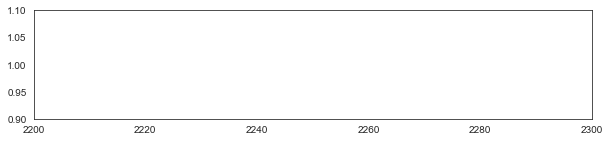

In [15]:
fig, ax = plt.subplots(figsize=(10,2))


plt.plot(trip_df.t, trip_df.detection_left, linestyle = 'None', marker='x', markersize=12, mew=2)
plt.plot(trip_df.t, trip_df.detection_right, linestyle='None', marker='x', markersize=12, mew=2)

# for _, row in lca_df.iterrows(): 
#     color = ('C0' if row.direction=='left' else 'C1')
#     plt.plot([row.t_start_approx, row.t_end_approx], [1, 1], c=color)

plt.ylim(0.9,1.1)
plt.xlim(2200,2300)
# plot_lane_changes(lca_dfs[trip_nr])



In [16]:
lca_df

,time start,time middle,from lane,to lane,total lanes,type,direction,multiple lanes,t_lc,frame_number,section,road type,t_start_approx,t_end_approx,detected,result
0,NaN,00.03.28.089,3,2,4,NaN,left,False,208.089,6236,A,straight,204.089,212.089,left,TP
1,NaN,00.03.54.545,2,3,3,NaN,right,False,234.545,7029,A,straight,230.545,238.545,none,FN
2,NaN,00.04.08.921,3,2,3,NaN,left,False,248.921,7460,A,straight,244.921,252.921,none,FN
3,NaN,00.04.34.390,2,3,3,NaN,right,False,274.390,8223,A,straight,270.390,278.390,none,FN
4,NaN,00.04.47.672,3,2,3,NaN,left,False,287.672,8622,A,straight,283.672,291.672,none,FN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,00.38.38.567,2,1,3,NaN,left,False,2318.567,69488,M,straight,2314.567,2322.567,none,FN
76,NaN,00.39.05.414,1,2,3,NaN,right,False,2345.414,70292,M,straight,2341.414,2349.414,none,FN
77,NaN,00.39.47.164,2,3,5,NaN,right,False,2387.164,71543,M,straight,2383.164,2391.164,right,TP
78,NaN,00.40.19.338,3,4,5,NaN,right,False,2419.338,72508,M,straight,2415.338,2423.338,right,TP


# Rolling window evaluation

In [18]:
# sliding window based evaluation
t0_w = trip_df.t.iloc[0]-.1 #t0 window
te_w = t0_w + params['LANE_CHANGE_DURATION']-.1 #t_end_window
total_duration = int(trip_df.t.iloc[-1]-trip_df.t.iloc[0])+1

t_window = [np.nan]*total_duration
window_labels = [np.nan]*total_duration
window_truths = [np.nan]*total_duration

for i in range(total_duration):
    
    window = list(trip_df[trip_df.t.between(t0_w, te_w)].detection.dropna())
    if 'left' in window:
        window_label = 'left'
    elif 'right' in window:
        window_label = 'right'
    else:
        window_label = 'none'
        
    
    window_truth_df = lca_df[lca_df.t_lc.between(t0_w, te_w)]
    if len(window_truth_df) == 0:
        window_truth = 'none'
    else:
        window_truth = window_truth_df.direction.iloc[0]
    
    t_window[i] = te_w+.1
    window_labels[i] = window_label
    window_truths[i] = window_truth
        
    t0_w += 1
    te_w += 1

df = pd.DataFrame({'t': t_window, 'window_label': window_labels, 'window_truth': window_truths})
df.loc[(df.window_label=='right')&(df.window_truth=='right'),'result'] = 'TP'
df.loc[(df.window_label=='left')&(df.window_truth=='left'),'result'] = 'TP'
df.loc[(df.window_label=='none')&(df.window_truth=='none'),'result'] = 'TN'
df.loc[(df.window_label!='none')&(df.window_truth=='none'), 'result'] = 'FP'
df.loc[(df.window_label=='none')&(df.window_truth!='none'), 'result'] = 'FN'
results = df.result.value_counts()


In [19]:
precision_recall_f1(results.TP,results.FN,results.FP)

(0.5056947608200456, 0.3712374581939799, 0.42815814850530376)

In [20]:
trip_df[trip_df.t.between(470,490)].detection_left

281   -1.0
282    0.0
283    0.0
284    0.0
285    0.0
286    0.0
287    0.0
288    0.0
289    0.0
290    0.0
291    0.0
292    0.0
293    0.0
294    0.0
295    0.0
296    0.0
297    0.0
298    0.0
299    0.0
300    0.0
Name: detection_left, dtype: float64

# plotting lane changes

In [18]:
trip_names[0][1]

'01 GPS GoPro downsampled (last).csv'

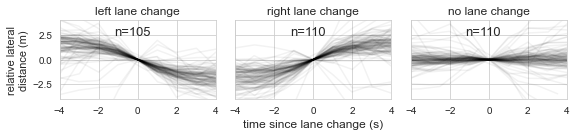

# statistical analysis for cases 

,device,sections,window_size,threshold,TP,FP,TN,FN,accuracy,TPR,FPR
0,GoPro downsampled (last),all,8,-5,215,212,3,0,0.506977,1.0,0.986047
1,GoPro downsampled (last),all,8,-4,215,210,5,0,0.511628,1.0,0.976744
2,GoPro downsampled (last),all,8,-3,213,210,5,2,0.506977,0.990698,0.976744
3,GoPro downsampled (last),all,8,-2,211,204,11,4,0.516279,0.981395,0.948837
4,GoPro downsampled (last),all,8,-1,210,184,31,5,0.560465,0.976744,0.855814
5,GoPro downsampled (last),all,8,0,208,110,105,7,0.727907,0.967442,0.511628
6,GoPro downsampled (last),all,8,1,201,35,180,14,0.886047,0.934884,0.162791
7,GoPro downsampled (last),all,8,2,189,12,203,26,0.911628,0.87907,0.055814
8,GoPro downsampled (last),all,8,3,128,7,208,87,0.781395,0.595349,0.032558
9,GoPro downsampled (last),all,8,4,56,3,212,159,0.623256,0.260465,0.013953


Text(0.5, 1.0, 'GoPro downsampled (last)')

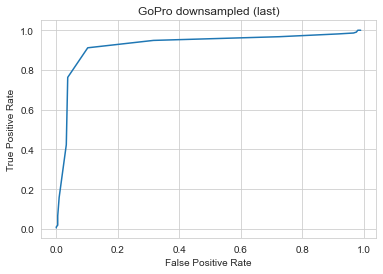

<AxesSubplot:xlabel='FPR'>

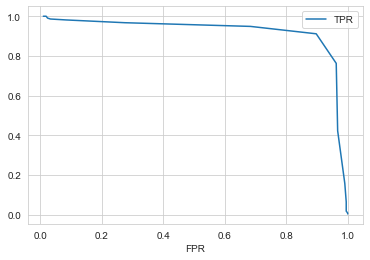

In [122]:
result_df.plot(x='FPR', y='TPR')

In [64]:


# fragment_diff = 


# for fragment in fragments_left:
#     plt.plot(fragment.t_fragment, -fragment.relative_signal)
#     negative_offset = -fragment.offset
#     fragment_diff = negative_offset.iloc[-1] - negative_offset.iloc[0]
#     fragment_outcome = fragment_diff > threshold
#     if fragment_outcome:
        
#     break
# print(fragment_diff)

215

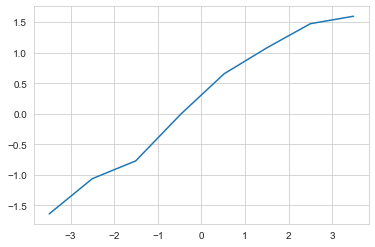

In [49]:
for fragment in fragments_right:
    plt.plot(fragment.t_fragment, fragment.relative_signal)
    break

# Scrap

minimum time between lane changes

In [23]:
for i_trip, lca_df in enumerate(lca_dfs):
    for direction in ['left', 'right']:
        min_t_diff = lca_df[lca_df.direction==direction].t_lc.diff().min()
        print("trip", i_trip, direction, "min_t_diff", min_t_diff)
       
    


trip 0 left min_t_diff 6.373000000000047
trip 0 right min_t_diff 4.0770000000002256
trip 1 left min_t_diff 5.579000000000065
trip 1 right min_t_diff 5.108999999999924
trip 2 left min_t_diff 5.956999999999994
trip 2 right min_t_diff 5.760999999999967


In [ ]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

In [ ]:
trip_df = trip_dfs[0][1]
trip_df

In [ ]:
calculate_offset

In [ ]:
from calculate_offset import offset

In [ ]:
off = trip_df.apply(lambda r: offset(
                r.bearing_road, r.x_road, r.y_road, r.x_gps, r.y_gps), axis=1)

In [ ]:
def offset2(bearing, x_road, y_road, x_gps, y_gps):
    len_ab = sqrt((x_gps-x_road)**2+(y_gps-y_road)**2)
    alpha = bearing - arctan((x_gps-x_road)/(y_gps-y_road))
    return len_ab*sin(alpha)

off2 = trip_df.apply(lambda r: offset2(
                r.bearing_road, r.x_road, r.y_road, r.x_gps, r.y_gps), axis=1)

In [ ]:
off2

In [ ]:
from numpy import arctan, sin, sqrt,pi
bearing = 51.86 *pi/180
a =(10.57,9.45)
b = (9.58,4.88)

print(offset2(bearing, b[0], b[1], a[0], a[1]))
print(offset(bearing, b[0], b[1], a[0], a[1]))

In [ ]:
off

In [ ]:
trip_df.iloc[0,:]

In [ ]:
trip_names[0][1]

In [ ]:
off

In [ ]:
trip_df[0]